In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from google.cloud import storage

import re, MeCab
from glob import glob
import mojimoji
import lightgbm as lgb

#環境変数,
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../auth/My First Project.json"
bucket_name = "pj_horidasimono"
prefix="dataset/train/ElectricalAppliance"
#最大表示行数の指定（ここでは50行を指定）
pd.set_option('display.max_rows', 200)
#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 200)

In [2]:
def road_data_from_gcs(bucket_name, prefix):
    client = storage.Client()
    blobs = client.list_blobs(bucket_name, prefix=prefix)
    df = pd.DataFrame()
    for blob in blobs:
        bucket = client.get_bucket(bucket_name)
        r = storage.Blob(blob.name, bucket)
        content = r.download_as_string()
        df = df.append(pd.read_json(content))
        print(f"read file {blob.name}...")

    df = df.reset_index(drop=True)
    df = df.drop_duplicates(subset="url")
    return df

## pklに保存

In [18]:
df = pd.read_pickle("data_20201009.pkl")

In [19]:

def preprocess(df):
    df["price"] = df["price"].str.replace(r"\D", "").astype(np.float)
    
    #列ズレを修正
    pattern = re.compile(r"^(?!.*(傷や汚れあり|全体的に状態が悪い|やや傷や汚れあり|未使用に近い|目立った傷や汚れなし|新品、未使用)).+$")
    invalid = df["status"].str.match(pattern)

    df.loc[invalid, "description"] = df.loc[invalid, "description"] + "\n" + df.loc[invalid, "status"]
    df.loc[invalid, "status"]      = df.loc[invalid, "shipping"]
    df.loc[invalid, "shipping"]    = df.loc[invalid, "method"]
    df.loc[invalid, "method"]      = df.loc[invalid, "region"]
    df.loc[invalid, "period"]      = "未定"
    
    status_dict = {'新品、未使用': "new",
                   '未使用に近い': "almost_new",
                   '目立った傷や汚れなし': "normal",
                   'やや傷や汚れあり': "little_poor",
                   '傷や汚れあり': "Poor",
                   '全体的に状態が悪い': "worst"
                  }
    
    #配送負担をラベルエンコーディング
    shipping_dict = {'送料込み(出品者負担)': 0, '着払い(購入者負担)': 1}

    df["status"] = df["status"].map(status_dict)
    df["shipping"] = df["shipping"].map(shipping_dict)
    
    return df

In [20]:
df = preprocess(df)

In [21]:
df.head()

,url,title,seller,rating,price,sub_category_1,sub_category_2,brand,status,shipping,method,region,period,description,recent_comment,timestamp
0,https://www.mercari.com/jp/items/m81188231578/,[ジャンク]iPhone SE Silver 32 GB SIMフリー,OZYA,48|0,3000.0,スマートフォン/携帯電話,スマートフォン本体,アップル,Poor,0,ゆうゆうメルカリ便,兵庫県,2~3日で発送,iPhone SE Silver 32 GB SIMフリー\n最近まで使用していた、ipho...,\t,2020-09-21 19:41:30.593
1,https://www.mercari.com/jp/items/m60823230368/,GLIDiC TW 5000s,れんげ,65|0,4000.0,オーディオ機器,イヤフォン,,best,0,らくらくメルカリ便,東京都,1~2日で発送,ワイヤレスイヤホンです。\n新品未使用です。\n1度も開封せず、自宅保管しおりました。\n使...,3 分前,2020-09-21 19:41:30.593
2,https://www.mercari.com/jp/items/m92753660301/,ZOOM H2SJ,ブロダ,15|0,5000.0,オーディオ機器,その他,,Very Good,0,クロネコヤマト,京都府,1~2日で発送,ハンディタイプのレコーダです\n風防付きなので屋外での録音に最適です\n数回しか使って無いの...,10 分前,2020-09-21 19:41:30.593
3,https://www.mercari.com/jp/items/m52720784155/,"Canon プリンタインク純正品6色セット 350,351 標準容量",のりをかか,7|0,2500.0,PC/タブレット,PC周辺機器,キヤノン,best,0,らくらくメルカリ便,大阪府,1~2日で発送,"プリンタ買い替えに伴い余剰になったので出品します。\n\nPGBK,BK,GYはセット品を購...",46 分前,2020-09-21 19:41:30.593
4,https://www.mercari.com/jp/items/m71198446423/,Panasonic NP-TCM4 2018年,なな,438|0,21000.0,生活家電,その他,,good,0,らくらくメルカリ便,長野県,1~2日で発送,ご覧いただきありがとうございます。\n\nPanasonic 食洗機 NP-TCM4\n知り...,47 分前,2020-09-21 19:41:30.593


## カテゴリ調査

In [48]:
df_category2_top10 = df.groupby("sub_category_2")["sub_category_2", "price"].agg(["count", "mean"])["price"].reset_index().sort_values(by="count", ascending=False)[1:11]["sub_category_2"]

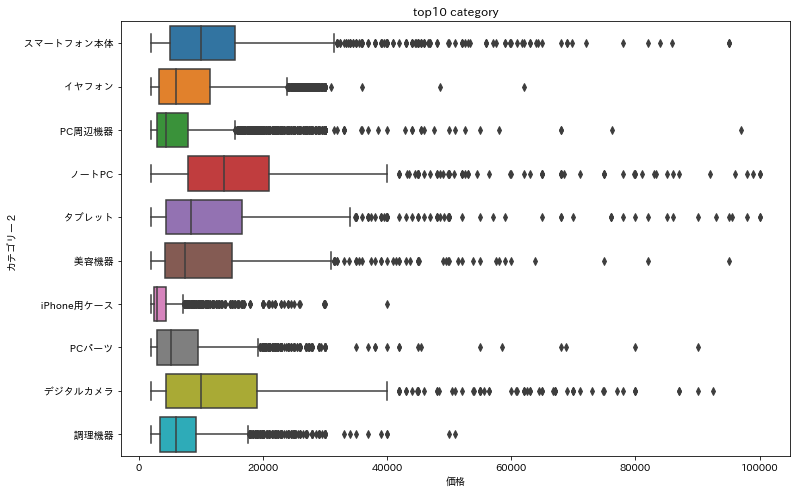

In [49]:
plt.figure(figsize=(12,8))
sns.boxplot(x="price", y="sub_category_2", data=df[df["sub_category_2"].isin(df_category2_top10)])
plt.ylabel("カテゴリー２")
plt.xlabel("価格")
plt.title("top10 category")
plt.show()

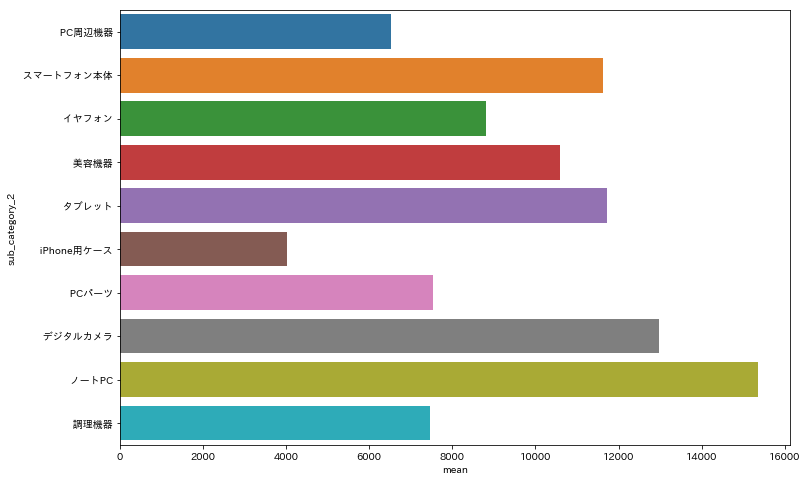

In [31]:
plt.figure(figsize=(12,8))
sns.barplot("mean", "sub_category_2", data=df_category_top10)
plt.show()

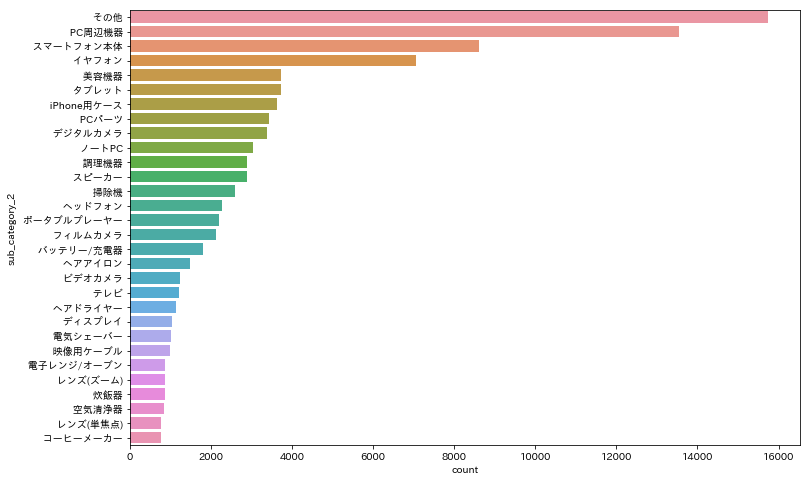

In [53]:
plt.figure(figsize=(12,8))
sns.barplot("count", "sub_category_2", data=df_category_sum.sort_values(by="count", ascending=False)[:30])
plt.show()

## ブランド調査

In [63]:
df_brand_top10 = df.replace("", "unknown")
df_brand_top10 = df_brand_top10.groupby("brand").agg(["count", "mean"])["price"].sort_values(by="count", ascending=False).reset_index()[1:11]

In [64]:
df_brand_top10

,brand,count,mean
1,アップル,12985,11486.486330
2,パナソニック,5296,8565.023225
3,ソニー,4857,9517.515339
4,キヤノン,2918,9365.202193
5,シャープ,2244,9499.073975
6,アマゾン,1580,5419.853797
7,東芝,1456,9590.703984
8,ニコン,1258,12252.578696
9,エプソン,1079,5963.104727
10,オリンパス,902,10016.831486


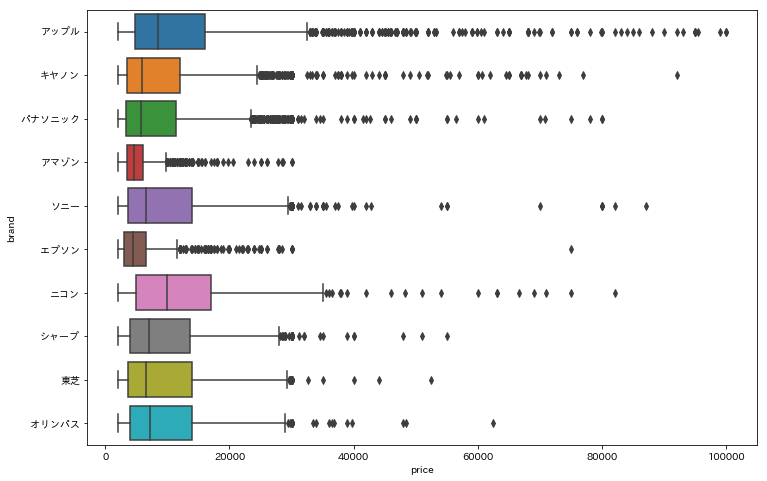

In [62]:
plt.figure(figsize=(12,8))
sns.boxplot(x="price", y="brand", data=df[df["brand"].isin(df_brand_top10)])
plt.show()

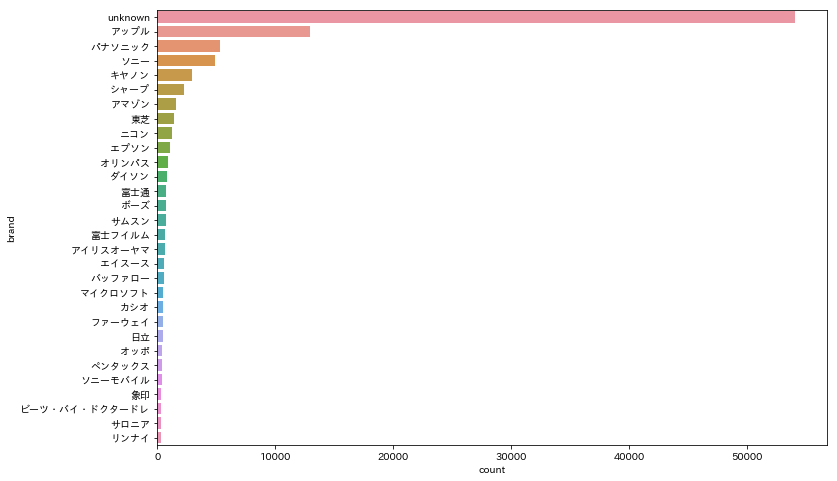

In [67]:
plt.figure(figsize=(12,8))
sns.barplot("count", "brand", data=df_brand_sum.sort_values(by="count", ascending=False)[:30])
plt.show()

## 配送負担

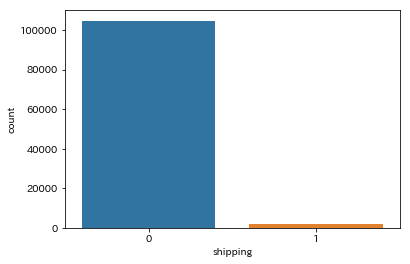

In [65]:
sns.countplot(df["shipping"])
plt.show()

## 価格

In [91]:
df.describe()

,price,shipping
count,106743.000000,106743.000000
mean,8659.250555,0.019271
std,7813.583494,0.137475
min,2000.000000,0.000000
25%,3300.000000,0.000000
50%,5740.000000,0.000000
75%,11500.000000,0.000000
max,100000.000000,1.000000


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


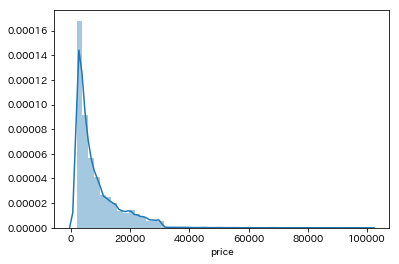

In [89]:
sns.distplot(df["price"])
plt.show()

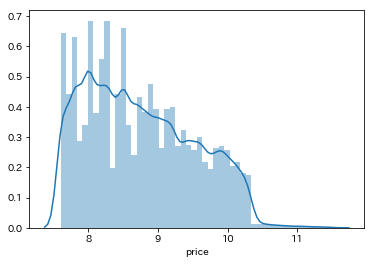

In [90]:
sns.distplot(np.log(df["price"]))

## 配送期間

In [88]:
df_period = df[["period", "price"]]
df_period = pd.get_dummies(df_period)
df_period.corr()["price"]

price             1.000000
period_1~2日で発送    0.009653
period_2~3日で発送   -0.023114
period_4~7日で発送   -0.013178
period_未定         0.060389
Name: price, dtype: float64

## 状態の影響

In [114]:

rank = {"Poor":2, "Very Good":4, "best": 5, "good":3, "very poor":1, "worst":0}

df_condition = df[df["brand"]=="アップル"][["status", "price"]]
df_condition = pd.get_dummies(df_condition)
df_condition.corr()["price"]

price               1.000000
status_Poor        -0.084671
status_Very Good    0.031702
status_best         0.024247
status_good         0.100836
status_very poor   -0.056698
status_worst       -0.070456
Name: price, dtype: float64

,price,status_Poor,status_Very Good,status_best,status_good,status_very poor,status_worst
price,1.000000,-0.034165,0.035376,-0.099018,0.096426,0.013262,-0.045001
status_Poor,-0.034165,1.000000,-0.093426,-0.175301,-0.174200,-0.126632,-0.039666
status_Very Good,0.035376,-0.093426,1.000000,-0.236876,-0.235387,-0.171112,-0.053598
status_best,-0.099018,-0.175301,-0.236876,1.000000,-0.441671,-0.321067,-0.100570
status_good,0.096426,-0.174200,-0.235387,-0.441671,1.000000,-0.319050,-0.099938
status_very poor,0.013262,-0.126632,-0.171112,-0.321067,-0.319050,1.000000,-0.072648
status_worst,-0.045001,-0.039666,-0.053598,-0.100570,-0.099938,-0.072648,1.000000
